In [68]:
import gzip
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import string
import random
import string
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE
import json
import dateutil
import time
import warnings
warnings.filterwarnings("ignore")

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
data = []
ratingsTime = []
f = gzip.open('renttherunway_final_data.json.gz', 'r')
for l in f:
    try:
        x = eval(l)
        
        # Data cleaning: convert height, weight, and rating to integer types
        x['rating'] = int(x['rating'])

        t = dateutil.parser.parse(x['review_date'])
        ratingsTime.append((t,x['rating']))

        if 'age' in x:
            x['age'] = int(x['age'])
        if 'weight' in x:
            x['weight'] = int(x['weight'][:-3])
        if 'height' in x:
            feet = int(x['height'][0])
            inches = int(x['height'][-3:-1].strip(" "))
            x['height'] = (feet * 12) + inches

        data.append(x)
    except NameError:
        continue
for l in f:
    try:
        x = eval(l)
        data.append(x)
    except NameError:
        continue

In [74]:
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': 137,
 'rating': 10,
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': 68,
 'size': 14,
 'age': 28,
 'review_date': 'April 20, 2016'}

In [66]:
df = pd.DataFrame(data)
df['review_date']  = pd.to_datetime(df['review_date'])
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14
3,fit,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
4,fit,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192457,fit,66386,34dd,2252812,140.0,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,69.0,8,42.0,2016-05-18
192458,fit,118398,32c,682043,100.0,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,61.0,4,29.0,2016-09-30
192459,fit,47002,36a,683251,135.0,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,68.0,8,31.0,2016-03-04
192460,fit,961120,36c,126335,165.0,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,66.0,16,31.0,2015-11-25


In [36]:
df.describe()

,weight,rating,height,size,age
count,162505.000000,192462.000000,191785.000000,192462.000000,191503.000000
mean,137.393649,9.092371,65.310707,12.245254,33.869955
std,21.901410,1.430044,2.663612,8.495463,8.057671
min,50.000000,2.000000,54.000000,0.000000,0.000000
25%,123.000000,8.000000,63.000000,8.000000,29.000000
50%,135.000000,10.000000,65.000000,12.000000,32.000000
75%,148.000000,10.000000,67.000000,16.000000,37.000000
max,300.000000,10.000000,78.000000,58.000000,117.000000


In [16]:
df['fit'].value_counts(normalize=True)
# trying to see if 

fit      0.737782
small    0.133928
large    0.128290
Name: fit, dtype: float64

In [31]:
df.groupby('fit')['rating'].mean()

fit
fit      9.308469
large    8.551942
small    8.419615
Name: rating, dtype: float64

In [32]:
df.groupby('fit')['rating'].median()

fit
fit      10
large     8
small     8
Name: rating, dtype: int64

We see that people tend to rate lower when clothes doesn't fit them, which is to be expected.
We will use the fit column as one of our features to predict ratings.
Since the label is imbalanced, we may not see too much improvement in our model but we will give it a try.

Next, we will do some temporal analysis to check if time is a good predictor for rating.

In [37]:
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14
3,fit,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
4,fit,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192457,fit,66386,34dd,2252812,140.0,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,69.0,8,42.0,2016-05-18
192458,fit,118398,32c,682043,100.0,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,61.0,4,29.0,2016-09-30
192459,fit,47002,36a,683251,135.0,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,68.0,8,31.0,2016-03-04
192460,fit,961120,36c,126335,165.0,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,66.0,16,31.0,2015-11-25


In [57]:
temporal = df.copy()
temporal['day'] = df['review_date'].dt.day_name()
temporal.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,day
0,fit,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20,Wednesday
1,fit,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18,Tuesday
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14,Monday
3,fit,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12,Wednesday
4,fit,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26,Monday


<AxesSubplot:xlabel='day', ylabel='rating'>

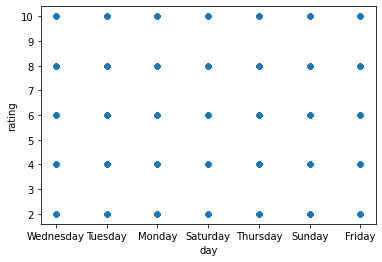

In [60]:
temporal.plot(x='day', y='rating', kind='scatter')

Sliding window

In [75]:
ratingsTime.sort()
len(ratingsTime)

192462

In [76]:
ratingsTime[:5]

[(datetime.datetime(2010, 11, 3, 0, 0), 10),
 (datetime.datetime(2011, 2, 14, 0, 0), 8),
 (datetime.datetime(2011, 2, 23, 0, 0), 10),
 (datetime.datetime(2011, 2, 24, 0, 0), 10),
 (datetime.datetime(2011, 3, 6, 0, 0), 10)]

In [77]:
wSize = 1000
x = [r[0] for r in ratingsTime] # as raw times
y = [r[1] for r in ratingsTime] # ratings
xu = [time.mktime(d.timetuple()) for d in x] # as unix times

In [78]:
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [79]:
for i in range(wSize,len(x)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

In [80]:
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

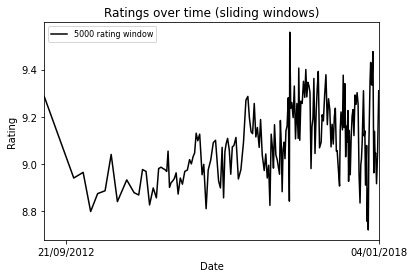

In [82]:
plt.plot(X[::1000],Y[::1000], label="5000 rating window", color='k')
plt.xticks([X[600], X[-350]], [x[wSize+600].strftime("%d/%m/%Y"), x[-350].strftime("%d/%m/%Y")])
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
plt.show()